In [1]:
# %matplotlib inline
%matplotlib widget
%load_ext autoreload
%autoreload 2
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import os
import sys
sys.path.insert(0, 'functions/')
from h5_tools import *
from fitting_tools import *
from tools import *
# from h5_tools import *
import numpy as np
import h5py as h5
import matplotlib as mpl
from matplotlib import pyplot as plt
from scipy.ndimage import gaussian_filter
# import pandas as pd

# plot general settings
mpl.rcParams.update({"axes.grid" : True, "grid.color": "gray", "grid.linestyle":":", "grid.alpha": "0.5", "font.size": 16})
plt.rcParams['legend.title_fontsize'] = 'small'

import scipy as sp
import scipy.interpolate

In [2]:
h5dir = '/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/20220614/processed/h5-files/'

# Load files

#### Background ID10 

In [127]:
# bkg 0003 blank
f = np.load("../03-source/bkg_background_0003.npz")
print(f.files)
# Iq_bkg = np.average(f['Iq'][:2,:], axis=0)
# Iq_bkg = np.where(f['Iq']==0, np.nan, f['Iq'])
q_bkg = f['q']
t_exp_bkg = 1e-1

# water/glycerol
f = np.load("../03-source/bkg_water_gly_50_2_0002.npz")
print(f.files)
# Iq_bkg = np.average(f['Iq'][:2,:], axis=0)
Iq_bkg_w = f['Iq'][2,:]
# Iq_bkg_w = np.where(f['Iq'][2,:]==0, np.nan, f['Iq'][2,:])
q_bkg_w = f['q']
# q_bkg_w = q_bkg_w[f['Iq'][2,:] != 0]
t_exp_bkg_w = 1e-1

# apoferritin
# f = np.load("../03-source/Iqs_apo_conc_gly_50_2_0006.npz")
# f.files
# Iq_apo = np.average(f['Iqs'],axis=0)
# q_apo = f['q']
# t_exp_apo = 5e-3

# apoferritin short exp time
f = np.load("../03-source/bkg_apo_conc_gly_50_2_0002.npz")
f.files
Iq_apo = f['Iq']
# Iq_apo = np.where(f['Iq']==0, np.nan, f['Iq'])
q_apo = f['q']
t_exp_apo = 0.0002

['Iq', 'q']
['Iq', 'q']


In [128]:
def expon(x, a,b,c, d):
    return a * np.exp(-x/b + c) + d

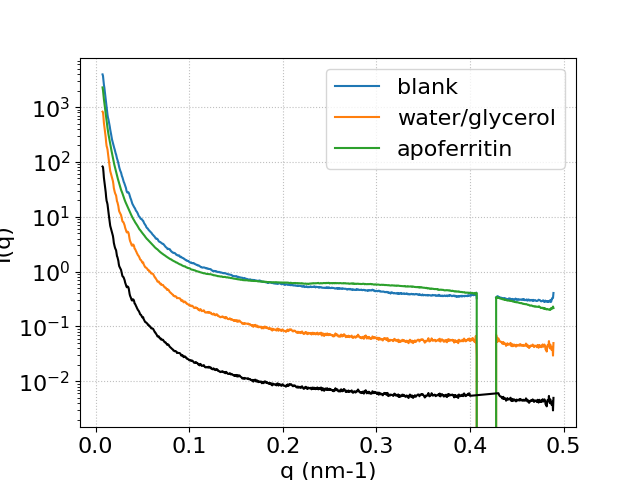

In [193]:
plt.figure()

plt.plot(q_bkg, Iq_bkg / t_exp_bkg, label='blank')
plt.plot(q_bkg_w, Iq_bkg_w / t_exp_bkg_w, label='water/glycerol')
plt.plot(q_apo, Iq_apo / t_exp_apo, label='apoferritin')

# q_bk = q_bkg[(q_bkg<0.4) | (q_bkg>0.43)]
# Iq_bk = Iq_bkg[(q_bkg<0.4) | (q_bkg>0.43)]

q_bk = q_bkg_w[(q_bkg_w<0.4) | (q_bkg_w>0.43)]
Iq_bk = Iq_bkg_w[(q_bkg_w<0.4) | (q_bkg_w>0.43)]

plt.plot(q_bk, Iq_bk, c='k')
# popt, xc, curve, perr = fit(expon, q_bkg[q_bkg<0.4], Iq_bkg[q_bkg<0.4] / t_exp_bkg, p0=[1e3, .1, 0, 0.1], )
# np.poly( q_bkg[q_bkg<0.4], Iq_bkg[q_bkg<0.4] / t_exp_bkg, )

# plt.plot(xc,curve,ls='--')
# plt.axvline()
plt.xlabel('q (nm-1)')
plt.ylabel('I(q)')
plt.legend()
plt.yscale('log')

# plt.xscale('log')

#### ID02 ferritin

In [4]:
f = np.load('../03-source/id02/Iqs.npz')
# f.files
Iqs_id02 = f['Iqs']
q_id02 = f['q']
c_id02 = f['concs']
print(np.shape(Iqs_id02), np.shape(q_id02))

(5, 1500) (1500,)


In [238]:
c_id02

array([404, 180,  70,  10])

(0.0, 1.5)

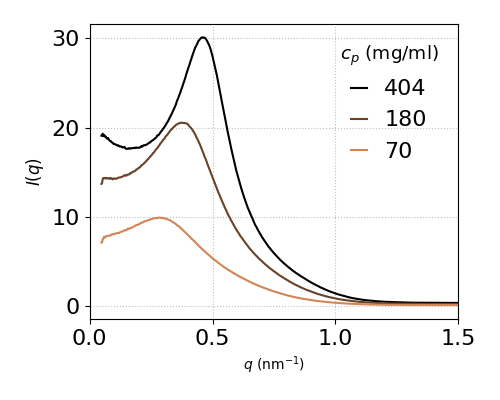

In [46]:
f, a1 = plt.subplots(1,1,figsize=(5,4), tight_layout=True)
# -- id02
cols = plt.cm.copper(np.linspace(0,1,len(Iqs_id02)-1))

for j in range(len(Iqs_id02)-2):
    # qi_min, qistep, qi_max = 43, 10, 155
    # b2 = Iqs_id02[j,qi_min]
    # A2 = np.nanmax(Iqs_id02[j,qi_min:qi_max]-b2)

    a1.plot(q_id02, Iqs_id02[j,:], label=c_id02[j], c=cols[j])

# -- plot settings
a1.legend(title='$c_p$ (mg/ml)', handlelength=.7, frameon=False, ncol=1)
a1.set_xlabel(r'$q$ (nm$^{-1}$)', fontsize=10)
a1.set_ylabel('$I(q)$', fontsize=12)
# a1.set_yscale('log')
# a1.set_xlim(.18,qI[-1])
a1.set_xlim(0, 1.5)



#### ID10 ferritin Iqs

In [145]:
# c1 temps 250-210 K full beam
runnames = ['ferritin_conc_gly_50_6']
datasetnumbers = [2,3,4,5,6]
T, Tr = [], []

if len(runnames) == 1:
    runnames = runnames*len(datasetnumbers)

for i,(datasetnumber, runname) in enumerate(zip(datasetnumbers, runnames)):
    filename = h5dir + f'{runname}_{datasetnumber:04d}.h5'

    if os.path.isfile(filename):
        print(filename, "\nFile exists: ", os.path.isfile(filename), "\n")
        info = elog_selected_entries_dict(filename)
        for key in info.keys():
            print("{0:20} {1}".format(key, info[key]))
        Tr.append(info['transmission (%)'])
        T.append(info['Temperature, K'])
    else:
        print(filename, "\nFile exists: False")


/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/20220614/processed/h5-files/ferritin_conc_gly_50_6_0002.h5 
File exists:  True 

measurement folder   ferritin_conc_gly_50_6_0002
Temperature, K       250.0
transmission (%)     100
Absorbers 80um       0.0
Absorbers 100um      0.0
Short comment        nan
comment              xpcs, 4 reps per spot, 250K, full beam
Exposure time (s)    0.0002
number of frames     5000.0
/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/20220614/processed/h5-files/ferritin_conc_gly_50_6_0003.h5 
File exists:  True 

measurement folder   ferritin_conc_gly_50_6_0003
Temperature, K       240.0
transmission (%)     100
Absorbers 80um       0.0
Absorbers 100um      0.0
Short comment        nan
comment              xpcs, 4 reps per spot, 240K, full beam
Exposure time (s)    0.0002
number of frames     5000.0
/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/20220614/processed/h5-files/ferritin_conc_gly_50_6_0004.h5 
File exists:  True 

measurement folder   ferritin_conc_gly_50_6_0004
Temp

In [146]:
filename = h5dir + f'{runname}_{datasetnumbers[0]:04d}.h5'
rep = 0
qI = load_data(filename, '/saxs/q') # 1000

Iqs = np.empty(shape=(len(datasetnumbers),len(qI)))
t_exp = []

for i,(datasetnumber) in enumerate(datasetnumbers):
    filename = h5dir + f'{runname}_{datasetnumber:04d}.h5'
    Iqs[i,:] = load_data(filename, '/saxs/I_reps_filtered')[rep,:] # (4, 1000)
    info = elog_selected_entries_dict(filename)
    t_exp.append(load_data(filename, 'xpcs/g2s/delay')[0])
    print(datasetnumber, f'{t_exp[i]:.4f}', 's')

print(np.shape(Iqs), np.shape(qI))

2 0.0002 s
3 0.0002 s
4 0.0002 s
5 0.0002 s
6 0.0002 s
(5, 1000) (1000,)


(0.0, 1.5)

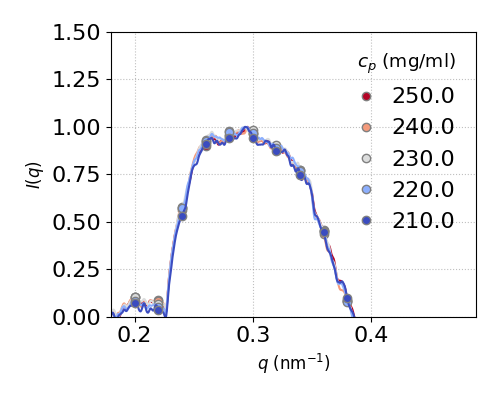

In [147]:
f, a1 = plt.subplots(1,1, figsize=(5,4), tight_layout=True)
# -- left id10
col = plt.cm.coolwarm_r(np.linspace(0,1,len(datasetnumbers)))
q_new = np.linspace(0.068, 0.468, 20)

Iq_interp, q_interp = [], []

# c_id10 = ['c1', 'c2', 'c3']
for i in range(len(datasetnumbers)):
    y = Iqs[i,:]/t_exp[i]
    y_smooth = gaussian_filter(y, sigma=2)
    qi_min, qistep, qi_max = 320, 30, -20
    b = np.mean(y_smooth[qi_min:qi_min+qistep])
    b = y_smooth[qi_min]
    A = np.nanmax(y_smooth[qi_min:qi_max]-b)
    if i==0:
        q_new = np.linspace(0.068, 0.37, 20)
        q_new = np.arange(0.2, 0.4, 0.02)
    else:
        q_new = np.linspace(0.2, 0.468, 20)
        q_new = np.arange(0.2, 0.5, 0.02)
    # a1.plot(qI, y, ls='--',  c=col[i]) 
    a1.plot(qI, (y_smooth-b)/A, ls='-',  c=col[i]) 

    # interpolate
    y_interp =  sp.interpolate.interp1d(qI, (y_smooth-b)/A, kind='linear')
    a1.plot(q_new, y_interp(q_new), marker='o', mec='gray', c=col[i], ls='',  label=T[i])#label=c_id10[i])
    q_interp.append(q_new)
    Iq_interp.append(y_interp(q_new))


# -- plot settings
a1.legend(title='$c_p$ (mg/ml)', handlelength=.7, frameon=False, ncol=1)
a1.set_xlabel(r'$q$ (nm$^{-1}$)', fontsize=12)
a1.set_ylabel('$I(q)$', fontsize=12)
a1.set_xlim(.18,qI[-1])
a1.set_ylim(0, 1.5)


#### DELTA

In [7]:
# -- load Michelle's data
path = '../03-source/delta/data_for_maddalena/'
bkg = np.array(np.genfromtxt(path + f'buffer_2_001.chi',skip_header=4,)[:])
qbkg = bkg[bkg[:,1]>0,0]
Ibkg = bkg[bkg[:,1]>0,1]


Use arrays `Iq_delta` and `q_delta`. Background subtracted

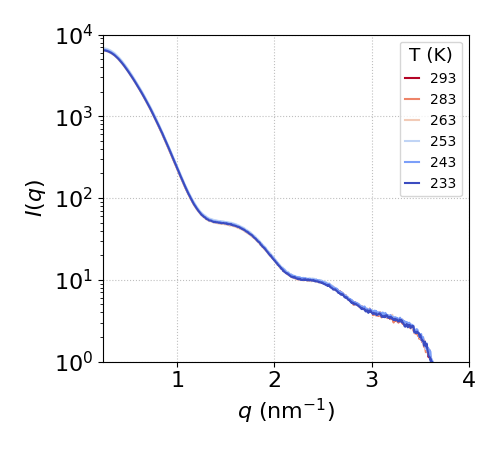

In [184]:
f, ax = plt.subplots(1,1, figsize=(5,4.5), tight_layout=True)

# T = [20,10,-10,-20,-30,-40,]#-50,-60,-70,-80]
temperatures=[20,10,-10,-20,-30,-40,]
T_delta = np.array(temperatures) + 273

temp = abs(np.array(temperatures))
colors = plt.cm.coolwarm_r(np.linspace(0,1,len(temperatures)))

txt_add = []
b_lim1, b_lim2 = 3.5, 4.5
ff = 4

Iq_delta, q_delta = np.empty(shape=(len(temperatures), len(Ibkg)-ff)), np.empty(shape=(len(temperatures), len(Ibkg)-ff))

for i,t in enumerate(temperatures):
    if t>=0:
        txt_add += ['']
    else :
        txt_add += ['m']

    data = np.array(np.genfromtxt(path + f'ferr_23mol_gly_t_{txt_add[i]}{temp[i]}_2_001.chi',skip_header=4,)[:])
    qdata = data[data[:,1]>0,0]
    Idata = data[data[:,1]>0,1]
    
    data_dil = np.array(np.genfromtxt(path + f'10mgpml_fer_gly_t_{txt_add[i]}{temp[i]}_2_001.chi',skip_header=4,)[:])
    qdat_dil = data_dil[data_dil[:,1]>0,0]
    Idata_dil = data_dil[data_dil[:,1]>0,1]
    
    scale = np.mean(Idata_dil[qdat_dil>b_lim1]) / np.mean(Idata[qdata>b_lim1])
    scale2 = np.mean(Ibkg[(qdata>b_lim1) & (qdata<b_lim2)]) / np.mean(Idata[(qdata>b_lim1) & (qdata<b_lim2)])
    
    Iq_delta[i,:] =  Idata[ff:] * scale2 - Ibkg[ff:]
    q_delta[i,:] = qdata[ff:]

    ax.plot(qdata[ff:], Idata[ff:] * scale2 - Ibkg[ff:], c=colors[i], label=temperatures[i]+273)

# -- settings
ax.legend(title='T (K)', handlelength=1, bbox_to_anchor=[1,1], fontsize=10)
ax.set_ylabel('$I(q)$', fontsize=16)
ax.set_xlabel(r'$q$ (nm$^{-1}$)', fontsize=16)
ax.set_yscale('log')
ax.set_xlim(qdata[ff],4)
ax.set_ylim(1e0,1e4)
ax.grid(ls=":", c='gray', alpha=0.5)

# Analysis

In [148]:
T_id10 = np.zeros(len(T))
for i in range(len(T)):
    T_id10[i] = float(T[i])

Arrays to use:
- Delta: `Iq_delta` (6, 838), `q_delta` (6, 838), `T_delta` (6) (background subtracted)
- ID02 RT: `Iqs_id02` (5, 1500), `q_id02` (5, 1500), `c_id02` (4) (backgorund subtracted - use len(Iqs_id02)-2)
- ID10 ferritin: `Iqs` (5,1000), `qI` (1000), `t_exp` (5), `T` (5) (no bg subtracted)
- ID10 bkg: 
    * blank: `Iq_bkg`, `q_bkg`, `t_exp_bkg`
    * wat/gly: `Iq_bkg_w`, `q_bkg_w`, `t_exp_bkg_w`
    * apoferritin: `Iq_apo`, `q_apo`, `t_exp_apo`

(1000.0, 10000.0)

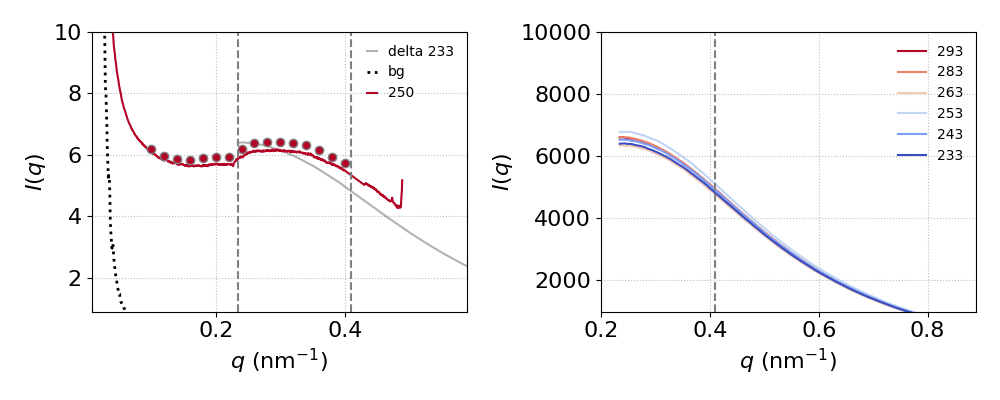

In [194]:
f, (a1, a2) = plt.subplots(1,2, figsize=(10,4), tight_layout=True)

# -- DELTA
col_delta = plt.cm.coolwarm_r(np.linspace(0,1,len(T_delta)))
for i in range(len(T_delta)):
    a2.plot(q_delta[i,:], Iq_delta[i,:], label=T_delta[i], c=col_delta[i])

j = len(T_delta) - 1
xi_norm = 37
n_delta = np.trapz(Iq_delta[j,:xi_norm], x=q_delta[j,:xi_norm])
# n_delta = Iq_delta[j,xi_norm]
a1.plot(q_delta[j,:], Iq_delta[j,:] / n_delta , label=f'delta {T_delta[j]}', c='gray', ls='-', alpha=0.6)

# -- ID10
q_new = np.linspace(0.068, 0.468, 20)
Iq_interp, q_interp = [], []
col = plt.cm.coolwarm_r(np.linspace(0,1,len(T_id10)))

# background
y_bkg = Iq_bk / t_exp_bkg
y_bkg = Iq_bk / t_exp_bkg
a1.plot(q_bk, y_bkg, ls=':', lw=2, c='k', label='bg')

# ferritin
for i in range(0,1):

    y = Iqs[i,:] / t_exp[i]
    y_smooth = gaussian_filter(y, sigma=2)
    
    y = y[(qI<0.4) | (qI>0.43)]
    q = qI[(qI<0.4) | (qI>0.43)]

    # normalize
    # n = np.mean(y[ (qI > q_delta[j,xi_norm]-0.01) & (qI < q_delta[j,xi_norm]+0.01)])
    n = np.trapz(y[(q > q_delta[j,0]) & (q < q_delta[j,xi_norm])], q[(q > q_delta[j,0]) & (q < q_delta[j,xi_norm])])
    
    a1.plot(q, y, c=col[i], label=f'{T_id10[i]:.0f}', ls='-')

    
    # a1.plot(q, y / n - y_bkg, c=col[i],  ls=':')
    
    q_new = np.arange(0.1, 0.4, 0.02)
    y_interp =  sp.interpolate.interp1d(q, y - y_bkg, kind='linear')

    n = np.trapz(y_interp(q_new)[(q_new > q_delta[j,0]) & (q_new < q_delta[j,xi_norm])], q_new[(q_new > q_delta[j,0]) & (q_new < q_delta[j,xi_norm])])
    a1.plot(q_new, y_interp(q_new) / n, marker='o', mec='gray', c=col[i], ls='',)#label=c_id10[i])

a2.axvline(x=q_delta[j,xi_norm], ls='--', c='gray')
a1.axvline(x=q_delta[j,xi_norm], ls='--', c='gray')
a1.axvline(x=q_delta[j,0], ls='--', c='gray')

# -- plot settings
a1.legend(handlelength=.7, frameon=False, ncol=1, fontsize=10)
a1.set_xlabel(r'$q$ (nm$^{-1}$)')
a1.set_ylabel('$I(q)$')
# a1.set_yscale('log')
a1.set_xlim(qI[0], qI[-1]+0.1)
a1.set_ylim(0.9, 10)

a2.legend(frameon=False, ncol=1, fontsize=10)
a2.set_xlabel(r'$q$ (nm$^{-1}$)')
a2.set_ylabel('$I(q)$')
# a2.set_yscale('log')
a2.set_xlim(q_delta[i,0], 3.2)
a2.set_ylim(1,1e4)
a2.set_xlim(0.2, qI[-1]+0.4)
a2.set_ylim(1e3,1e4)

In [195]:
q_delta[j,0]

0.23427759

In [275]:

def minimize_bg(q_new, a, b):
    """ y: Iq to optimize
        y_bk: Iq bkg
        q_new: q vals for optimized Iq
        q_norm: q range for normalization
    """
    # y, y_bk,
    # bkg = a *  Iq_bk / t_exp_bkg  + b
   

    # plt.plot(q_bkg, Iq_bkg / t_exp_bkg, label='blank')
    # plt.plot(q_bkg_w, Iq_bkg_w / t_exp_bkg_w, label='water/glycerol')
    # plt.plot(q_apo, Iq_apo / t_exp_apo, label='apoferritin')

    # q_bk = q_bkg[(q_bkg<0.4) | (q_bkg>0.43)]
    # Iq_bk = Iq_bkg[(q_bkg<0.4) | (q_bkg>0.43)]
    # q_norm = (0.2343, 0.4)

    q_bk = q_bkg_w[(q_bkg_w<0.4) | (q_bkg_w>0.43)]
    Iq_bk = Iq_bkg_w[(q_bkg_w<0.4) | (q_bkg_w>0.43)] / t_exp_bkg_w
    
    # q_bk = q_apo[(q_apo<0.4) | (q_apo>0.43)]
    # Iq_bk = Iq_apo[(q_apo<0.4) | (q_apo>0.43)] / t_exp_apo
    

    bkg = a *  Iq_bk  + b

    y_interp =  sp.interpolate.interp1d(q, y - bkg , kind='linear')
    y_array = y_interp(q_new)
    
    n = np.trapz(y_array[(q_new > q1) & (q_new < q2)], q_new[(q_new > q1) & (q_new < q2)])
    
    return y_array / n



def minimize_bg_2(q_new, a, b, c, d):
    """ y: Iq to optimize
        y_bk: Iq bkg
        q_new: q vals for optimized Iq
        q_norm: q range for normalization
    """


    q_bk = q_bkg_w[(q_bkg_w<0.4) | (q_bkg_w>0.43)]
    Iq_bk = Iq_bkg_w[(q_bkg_w<0.4) | (q_bkg_w>0.43)] / t_exp_bkg_w



    bkg = a *  Iq_bk  + b + c*q + d*q**2

    y_interp =  sp.interpolate.interp1d(q, y - bkg  , kind='linear')
    y_array = y_interp(q_new)
    
    n = np.trapz(y_array[(q_new > q1) & (q_new < q2)], q_new[(q_new > q1) & (q_new < q2)])
    
    return y_array / n



[ -4.9254264  -14.9806469  -31.69486985  95.40047742]


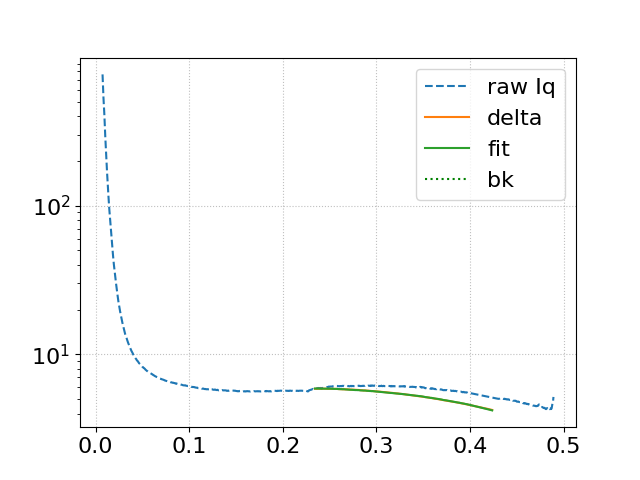

In [277]:
i = 0
y = Iqs[i,:] / t_exp[i]
y = y[(qI<0.4) | (qI>0.43)]
q = qI[(qI<0.4) | (qI>0.43)]


q_new = np.arange(0.1, 0.4, 0.02)
q_xpcs = np.array([0.108, 0.148, 0.188, 0.228, 0.268, 0.308, 0.348, 0.388, 0.428])
# f = minimize_bg(q_new, a=1, b=0)

plt.figure()
# plt.plot(q_new, f)
plt.plot(q, y, ls='--', label='raw Iq')
# plt.plot(q,  Iq_bk / t_exp_bkg, ls=':')

j = len(T_delta) - 1
xi_norm = 37


q1, q2 = 0.21, q_xpcs[-1]

q_ = q_delta[j,:][(q_delta[j,:]>q1) & (q_delta[j,:]<q2)]
Iq_ = Iq_delta[j,:][(q_delta[j,:]>q1) & (q_delta[j,:]<q2)]
n_delta = np.trapz(Iq_, x=q_)

plt.plot(q_, Iq_ / n_delta, label='delta')
# popt,xc,curve,perr = fit(minimize_bg, q_, Iq_ /  n_delta , p0=[1,0], bounds=[(-np.infty,-np.infty), (np.infty, np.infty)])
popt,xc,curve,perr = fit(minimize_bg_2, q_, Iq_ /  n_delta , p0=[1,0,1,1],)# bounds=[(-np.infty,-np.infty,-np.infty), (np.infty, np.infty, np.infty)])

plt.plot(xc, curve, label='fit')
print(popt)
plt.plot(q,  popt[0]*Iq_bk / t_exp_bkg + popt[1], ls=':', c='green', label='bk')
# print( popt[0]*Iq_bk / t_exp_bkg + popt[1])
# plt.xlim(q_[0], q_[-1])
# plt.ylim(4, 7)
plt.yscale('log')
plt.legend()

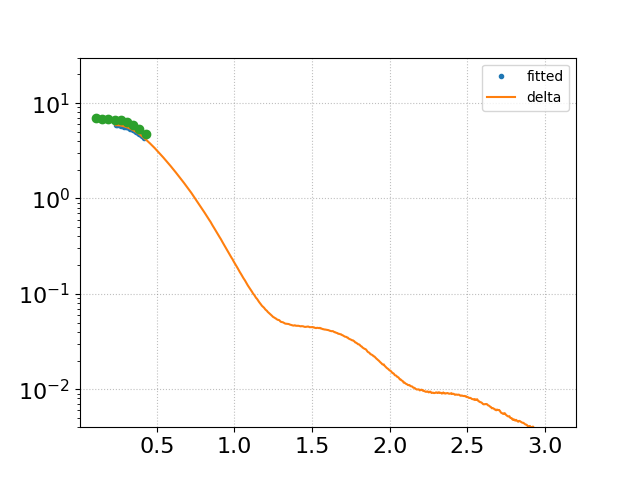

In [278]:
plt.figure()
# ferritin Iq ID10

i = 0
y = Iqs[i,:] / t_exp[i]
y = y[(qI<0.4) | (qI>0.43)]
q = qI[(qI<0.4) | (qI>0.43)]

n = np.trapz(y[(q > q1) & (q < q2)], q[(q > q1) & (q < q2)])

# a1.plot(q, y, c=col[i], label=f'{T_id10[i]:.0f}', ls='-')
q_bk = q_bkg_w[(q_bkg_w<0.4) | (q_bkg_w>0.43)]
Iq_bk = Iq_bkg_w[(q_bkg_w<0.4) | (q_bkg_w>0.43)] / t_exp_bkg_w

plt.plot(xc[::500], curve[::500], label='fitted', ls='', marker='.')
plt.plot(q_delta[j,:], Iq_delta[j,:] / n_delta, label='delta')

plt.plot(q_xpcs, minimize_bg_2(q_xpcs, *popt), marker='o')
# plt.plot(q, y - (popt[0] *  Iq_bk  + popt[1]), label='ferritin')

plt.yscale('log')
plt.xlim(0.005,3.2)
plt.ylim(4e-3, 3e1)
plt.legend(fontsize=10)

# ID02 data

[ -9.36473792   1.88784773 -76.94446561 139.83617395]


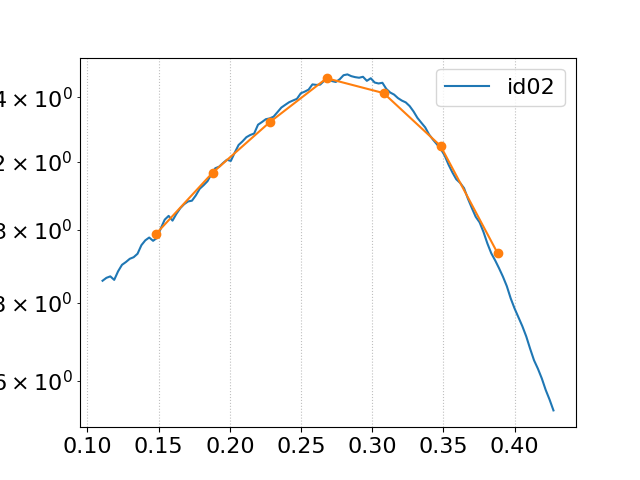

In [276]:
i = 0
y = Iqs[i,:] / t_exp[i]
y = y[(qI<0.4) | (qI>0.43)]
q = qI[(qI<0.4) | (qI>0.43)]


q_new = np.arange(0.1, 0.4, 0.02)
q_xpcs = np.array([0.108, 0.148, 0.188, 0.228, 0.268, 0.308, 0.348, 0.388, 0.428])

plt.figure()
# plt.plot(q, y, ls='--', label='raw Iq')
# plt.plot(q,  Iq_bk / t_exp_bkg, ls=':')

j = 2#len(T_delta) - 1
xi_norm = 37


q1, q2 = q_xpcs[0], q_xpcs[-1]

q_ = q_id02[(q_id02>q1) & (q_id02<q2)]
Iq_ = Iqs_id02[j,:][(q_id02>q1) & (q_id02<q2)]
n_ = np.trapz(Iq_, x=q_)

plt.plot(q_, Iq_ / n_, label='id02')
# popt,xc,curve,perr = fit(minimize_bg, q_, Iq_ /  n_ , p0=[1,0], bounds=[(-np.infty,-np.infty), (np.infty, np.infty)])
popt,xc,curve,perr = fit(minimize_bg_2, q_, Iq_ /  n_ , p0=[1,0,1,1],)# bounds=[(-np.infty,-np.infty), (np.infty, np.infty)])

# plt.plot(xc, curve, label='fit')
print(popt)
y_interp2 =  sp.interpolate.interp1d(xc, curve, kind='linear')
plt.plot(q_xpcs[1:-1], y_interp2(q_xpcs[1:-1]),  marker='o')

# plt.plot(q,  popt[0]*Iq_bk / t_exp_bkg + popt[1], ls=':', c='green', label='bk')
# plt.plot(q_xpcs, minimize_bg(q_xpcs, *popt), marker='o')

plt.yscale('log')
plt.legend()

In [256]:
q_xpcs[1]

0.148